In [215]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, data, restoration

%matplotlib inline

In [216]:
from google.colab import files
uploaded = files.upload()

Saving bottle.jpeg to bottle.jpeg


In [217]:
img  = cv2.imread('bottle.jpeg', 0)
rgb = cv2.imread('bottle.jpeg')

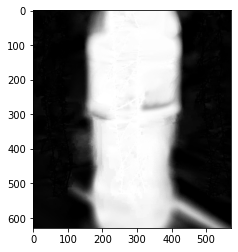

In [218]:
plt.imshow(img, cmap='gray')

In [219]:
def alphas(image):
    '''This will return the value of alphas provided the image'''
    M,N = image.shape
    alpha1 = np.zeros_like(image)
    alpha0 = np.zeros_like(image)
    threshold = image.max()
    
    for i in range(M):
        for j in range(N):
            if(image[i,j] != 0 and image[i,j] != threshold):
                alpha1[i,j] = image[i,j]
            else:
                alpha0[i,j] = image[i,j]
                
    
    return alpha0, alpha1

In [220]:
a0, a1 = alphas(img)

In [221]:
def filter_size(image):
    '''FINDS THE FILTER SIZE FROM THE TRANSPARANCY MAP'''
    a0 ,a1 = alphas(image)
    width, height = image.shape
    threshold = image.max()
    X1, X2 = 0,0 # X2 is right most point that has alpha value as threshold and X1 is the point with alpha value between 0 and threshold.
    Y1, Y2 = 0,0 #Y2 is the top most point that as alpha value as threshold and Y1 is the point with alpha value between 0 and threshold
    for i in range(width):
        for j in range(height):
            if(img[i,j] == threshold):
                X2 = max(X2, i)
                Y2 = max(Y2, j)
            else:
                X1 = max(X1, i)
                Y1 = max(Y1, j)
    
    width = X1 - X2 + 1
    height = Y1 - Y2 + 1
    return width, height ## X IS HEIGHT AND Y IS WIDTH SINCE ITS A COLUMN

In [222]:
print(filter_size(img))

(87, 170)


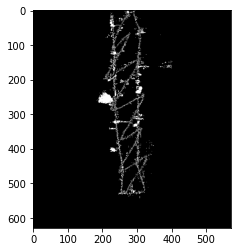

In [223]:
plt.imshow(a0, cmap='gray')

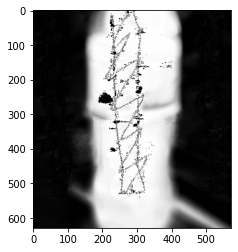

In [224]:
plt.imshow(a1, cmap='gray')

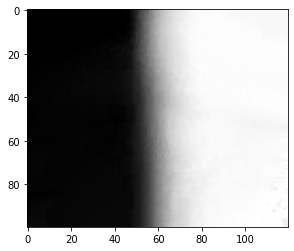

In [228]:
#Patch Selection

patches = []

patch = img[100:200, 100:220]
patches.append(patch)

patch = img[100:200, 380:450]
patches.append(patch)

plt.imshow(patches[0], cmap='gray')

In [230]:
#As mentioned in the paper, this method works better in small patches.
#Using the filter_size function an upper bound of the filter-size can
#be found out. 

patch = patches[0]
print(filter_size(patch))

(100, 120)


In [236]:
 

#patch = img[20: 70, 50:120]#img[45:60, 100:120]
#patch = img[20: 70, 50:120]

image = patch.copy()
#image = patch.copy()#img.copy()
filt_size = (20, 15)

summation_array = np.zeros_like(image, dtype = np.float64)

#filt_size = filter_size(image)#(10,10)
#filt_size = (15,15)#filter_size(image)

def loss(filt, image):



    a0, a1 = alphas(image)
    global summation_array


    
    #filt.resize(filt_size)#filter_size(image))
    filt = filt.reshape(filt_size)
    
    
    M, N = image.shape
    W, H = filt.shape

    c, d = int(W/2), int(H/2)

    a0, a1 = alphas(image)
    #a0 = a0/255
    #a1 = a1/255
    a0 = np.pad(a0, ((c, c), (d,d)))
    a1 = np.pad(a1, ((c, c), (d,d)))


    output = np.zeros_like(image, dtype=np.float64)
    for m in range(c, c+M):
        for n in range(d, d+N):
            summation = 0
            for w in range(W):
                for h in range(H):
                    summation = summation + a0[m-w, n-h] * filt[w,h]  
            
            summation_array[m-c,n-d] = summation
            output[m-c,n-d] = (a1[m,n] - summation)**2
            #print( normpdf(np.abs(a1[m,n] - summation), 0, 2), "test", output[m,n])   
    output[output==0] = 0.0000001
    print(np.log(np.sum(output)))      
    return np.log(np.sum(output)) * 1000


In [237]:
foptimal = None
def grad2(filt, image):
    global foptimal
    
    a0, a1 = alphas(image)
    
    #global a0, a1
    #filt.resize(filt_size)#filter_size(image))
    filt = filt.reshape(filt_size)
    M, N = image.shape
    W, H = filt.shape
    
    c, d = int(W/2), int(H/2)
    sigma = 2
    
    #a0 = a0/255
    #a1 = a1/255

    a0 = np.pad(a0, ((c, c), (d,d)))
    a1 = np.pad(a1, ((c, c), (d,d)))


    grad_helper = np.zeros_like(image, dtype=np.float64)
    
    grad = np.zeros_like(filt, dtype = np.float64)
    
    for k in range(W):
      for l in range(H):
        for m in range(c, c+M):
          for n in range(d, d+N):

            
            
            grad_helper[m-c,n-d] = - (a1[m,n] - summation_array[m-c,n-d]) * a0[m-k,n-l] 
        grad[k,l] = 2* np.sum(grad_helper)     

            
    foptimal = filt.copy()

    plt.imshow(restoration.richardson_lucy(image, foptimal.reshape(filt_size), iterations=10), cmap='gray')
    plt.show()


    return    grad.reshape(-1)


21.57888991058806


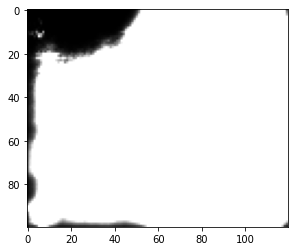

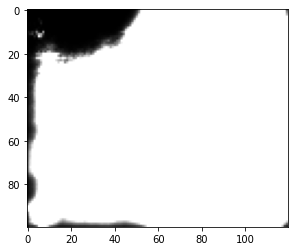

38.72478929385785


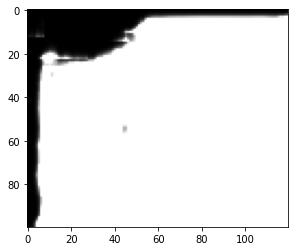

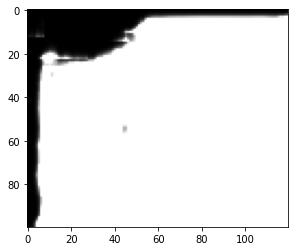

56.090708174827334


KeyboardInterrupt: ignored

In [238]:
epochs = 10000
lr = 0.00005
f0 = np.zeros(filt_size, dtype=np.float64)
f0 = np.random.random(size=filt_size).astype(np.float64)



for i in range(epochs):


  p = loss(f0, image)
  gradient = grad2(f0, image)
  f0 = f0 - (lr*gradient.reshape(filt_size))
  plt.imshow(restoration.richardson_lucy(image, foptimal.reshape(filt_size), iterations=10), cmap='gray')
  plt.show()


  





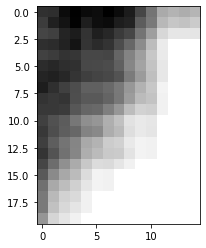

In [239]:
plt.imshow(foptimal.reshape(filt_size), cmap='gray')

In [240]:
patch_out = []  #To be used later while printing output

In [241]:
from scipy.signal import convolve
from scipy.signal import fftconvolve

In [211]:
def richardson_lucy(image, psf, iterations=50, clip=True):
    
    #image represents the input image which is blurred and is needed to be deconvolved with the obtained filter
    #Iterations are necessary to get a close approximation
    
    direct_time = np.prod(image.shape + psf.shape)
    fft_time =  np.sum([n*np.log(n) for n in image.shape + psf.shape])
    
    ## convolution method is faster (discussed in scikit-image PR #1792)
    time_ratio = 40.032 * fft_time / direct_time
    
    if time_ratio <= 1 or len(image.shape) > 2:      # Calculate the time required to calculate convolution 
        convolve_method = fftconvolve                # and selects more faster option  
    else:
        convolve_method = convolve
    
    image = image.astype(np.float)
    psf = psf.astype(np.float)
    im_deconv = 0.5 * np.ones(image.shape)           # Defining the deconvolved matrix which would be written over 
    psf_mirror = psf[::-1, ::-1]

    for _ in range(iterations):
        relative_blur = image / convolve_method(im_deconv, psf, 'same') #
        relative_blur[np.isnan(relative_blur)] = 0       ## to prevent NaN from propogating throughout convulated matrix
        relative_blur[np.isnan(relative_blur)] = 0       ## to prevent NaN from propogating throughout convulated matrix
        im_deconv *= convolve_method(relative_blur, psf_mirror, 'same')

    if clip:
        im_deconv[im_deconv > 1] = 1
        im_deconv[im_deconv < -1] = -1
    return im_deconv

In [242]:
out = richardson_lucy(image, f0, iterations=10, clip=True)

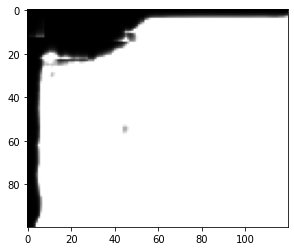

In [243]:
plt.imshow(out, cmap = 'gray')

In [244]:
patch_out.append(out)


In [ ]:
img = test.copy()
img[20:60, 100:120] = patch_out[0] * 255
img[25:40, 50:120] = patch_out[1] * 255
img[25:70, 50:70] = patch_out[2] * 255



In [ ]:
##Only to be used with user defined gradient descent algorithm.  

foptimal = None
def grad3(filt):
    global foptimal
    global a0, a1
    #filt.resize(filt_size)#filter_size(image))
    filt = filt.reshape(filt_size)
    M, N = image.shape
    W, H = filt.shape
    
    c, d = int(W/2), int(H/2)
    sigma = 2
    a0, a1 = alphas(image)
    #a0 = a0/255
    #a1 = a1/255

    a0 = np.pad(a0, ((c, c), (d,d)))
    a1 = np.pad(a1, ((c, c), (d,d)))


    grad_helper = np.zeros_like(image, dtype=np.float64)
    
    grad = np.zeros_like(filt, dtype = np.float64)
    
    for k in range(W):
      for l in range(H):
        for m in range(c, c+M):
          for n in range(d, d+N):
            summation = 0
            for w in range(W):
                for h in range(H):
                    summation = summation + a0[m-w, n-h] * filt[w,h]  
            
            
            
            
            grad_helper[m-c,n-d] = - (a1[m,n] - summation) * a0[m-k,n-l] 
        grad[k,l] = 2* np.sum(grad_helper)     

            #print( normpdf(np.abs(a1[m,n] - summation), 0, 2), "test", output[m,n])   
    #print(filt.max(), filt.min()) 
    foptimal = filt.copy()

    #plt.imshow(restoration.richardson_lucy(image, foptimal.reshape(filt_size), iterations=10), cmap='gray')
    #plt.show()


    return    grad.reshape(-1)


In [ ]:
epochs = 10000
lr = 0.00005
f0 = np.zeros(filt_size, dtype=np.float64)
f0 = np.random.random(size=filt_size).astype(np.float64)
for i in range(epochs):
  #np.ones(filt_size)#filter_size(image))
  #p = loss(f0)
  gradient = grad3(f0)
  f0 = f0 - (lr*gradient.reshape(filt_size))
  plt.imshow(restoration.richardson_lucy(image, foptimal.reshape(filt_size), iterations=20), cmap='gray')
  plt.show()

KeyboardInterrupt: ignored